In [ ]:
# pip install transformers==4.43.1
# pip install torch=2.0.0
# pip install datasets

In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # For running on GPU

In [2]:
import os
import time
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig
)
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding

import matplotlib.pyplot as plt
import seaborn as sns

## Load model

In [3]:
ACCESS_TOKEN_READ = "xxx" # Replace with HF access token
cache_dir = 'xxx' # Replace with desired cache_dir

In [4]:
model_name_or_path = 'meta-llama/Llama-2-7b-chat-hf'
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="left", cache_dir=cache_dir, use_auth_token=ACCESS_TOKEN_READ)

/home/jovyan/.conda/envs/transformers_latest/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:785: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


## Load data

In [5]:
# Load data as DataFrame
ds = load_dataset("therapara/summary-of-news-articles", cache_dir=cache_dir)
df = pd.DataFrame(ds['train'])

print(df.shape)
df.head()

(44972, 2)


,document,summary
0,"National Archives \n \n Yes, it’s that time ag...",– The unemployment rate dropped to 8.2% last m...
1,LOS ANGELES (AP) — In her first interview sinc...,"– Shelly Sterling plans ""eventually"" to divorc..."
2,"GAITHERSBURG, Md. (AP) — A small, private jet ...",– A twin-engine Embraer jet that the FAA descr...
3,Tucker Carlson Exposes His Own Sexism on Twitt...,– Tucker Carlson is in deep doodoo with conser...
4,A man accused of removing another man's testic...,– What are the three most horrifying words in ...


0.17693231343947344


/home/jovyan/.conda/envs/transformers_latest/lib/python3.11/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


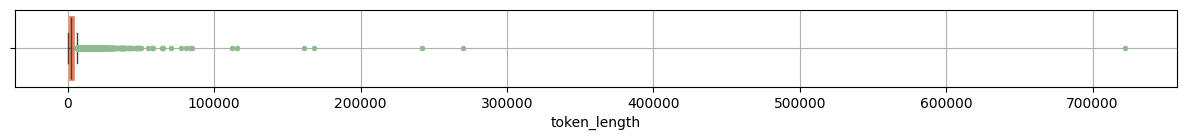

In [52]:
# (checking if dataset has more than 4096 for testing on llama2)
tqdm.pandas()
df['token_length'] = df['document'].progress_apply(lambda x: len(tokenizer(x)['input_ids']))

print(sum(df['token_length'] > 4096) / len(df))

plt.figure(figsize=(15, 1))
boxprops = dict(linewidth=2, color='coral')
flierprops = dict(marker='.', markerfacecolor='darkseagreen', markersize=8, markeredgecolor='none')
sns.boxplot(x=df['token_length'], boxprops=boxprops, flierprops=flierprops)
plt.grid()
plt.show()

In [6]:
# Choose example with > 10000 token length for testing
x = 294
example = df.iloc[x]

In [7]:
print("Token length:", example['token_length'])
print("\n==== Snippet of full document =====\n", example['document'][:500])
print("\n==== Summary =====\n", example['summary'])

Token length: 12588

==== Snippet of full document =====
 A host of hardy microbes may be living miles beneath the ocean floor, new research suggests. 
 
 Complex chemical compounds found in the rocks spewed from oceanic mud volcanoes suggest microbial life-forms may be dwelling some 32,800 feet (10,000 meters) beneath the seafloor. Though scientists have not yet found a smoking gun proving that life exists in these subterranean depths, similar chemical compounds have been found in other places where hardy microbes cling to life. 
 
 "Although we canno

==== Summary =====
 – A team of researchers may have discovered evidence of the deepest life on Earth (and we're not talking college freshmen taking their first philosophy class). According to a study published Monday in Proceedings of the National Academy of Sciences, there may be microbes living up to six miles under the seafloor. Researchers used a remotely operated vehicle to retrieve 46 samples of a rock called serpentine from a mu

## Run model without scaling

In [8]:
# Helper functions 
def infer(model, text, max_new_tokens=300):
    sentence = f"Read this document: {text} \nSummarise it in one sentence:"
    
    inputs = tokenizer(sentence, return_tensors="pt").to('cuda')
    print('Sentence token length:', len(inputs['attention_mask'][0]))
    
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    decoded_answer = decoded_outputs.replace(sentence, '')

    # This frees up gpu memory after each call
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(1)

    return decoded_answer

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    cache_dir=cache_dir, 
    device_map='auto',
    token=ACCESS_TOKEN_READ
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

In [12]:
model.config.max_position_embeddings

4096

In [21]:
%%time
infer(model, example['document'])

Sentence token length: 12602
CPU times: user 28.2 s, sys: 5.39 s, total: 33.6 s
Wall time: 37.3 s


'պЉЋ\nƏՄ.../ inЋЏՀЉЉЁգЋЪհЉЋЉЪՄհգЋշЁЏЩЉЉЉЉЉղՍգЏЏЉշЉЁզЉЉЪ\nЏՍպգ...ЉպհЏ C-Ћ.ЋգЉЩЋƏЪЋЏЉЪհЪƏ. ,ЋЪՍ PЋЁЉЪ..ղЉЪЉЋЉ. CЏЉЉЋ\nՍЋЋ.ЁЋզЉЪЋգ...\nЪnЋՄЉЉЪ...Ъ- PЋЋЉЪհЩЉՄզЋЉЏЋЋ ЉշЪքЉЏЉЪЉЉЉԱЪЉ CЉբշЉЏգЉЉЉЏҚՀՄЉЏƏЉքҚЉЪЋЉգЏЋЉ ЉղЉЪЉөբ NarodЁЉЉ P (ЏЉЪ CЉƏЉƏЉЉ NarodհЉՍЉЉ ( aЁ\nЉЋЪ (...Հ CЉЪЉЪЉЋЋքЉշЪЪƏөЏnЉ.ЉЪЋ PբЉ. , ЁЋЉղՍՍЪ,ЪհЪգЋЉЪ...շհЩЉЋ (ЋЁЉЏգշЋЉЊЋ C.հЉЋЪՄբЋЪЋհЋЋЉ,Љ'

## Add RoPE Scaling

### linear

In [8]:
ropeconfig_linear = AutoConfig.from_pretrained(model_name_or_path, cache_dir=cache_dir, token=ACCESS_TOKEN_READ)
ropeconfig_linear.rope_scaling = {"rope_type": "linear", "factor": 4}
ropeconfig_linear

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 4,
    "rope_type": "linear"
  },
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.43.1",
  "use_cache": true,
  "vocab_size": 32000
}

In [9]:
ropemodel_linear = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    config=ropeconfig_linear,
    cache_dir=cache_dir, 
    device_map='auto',
    token=ACCESS_TOKEN_READ
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
ropemodel_linear

# All rope configs are applied to LlamaRotaryEmbedding()!

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

In [13]:
%%time
s = infer(ropemodel_linear, example['document'])
s

Sentence token length: 12602


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


CPU times: user 29.1 s, sys: 6.07 s, total: 35.1 s
Wall time: 38.5 s


" Researchers have found evidence of microbes living three miles beneath the ocean floor in the deepest part of the ocean, near the Mariana Trench, suggesting that life may be able to survive in the most extreme environments.\n\nSummary: Scientists have discovered signs of life in the deepest part of the ocean, which could be three miles below the surface, after finding chemical compounds in rocks from the Mariana Trench, near the Mariana Trench, which could be indicative of microbial life.\nSummary: New study suggests life may exist three miles deep in the ocean's crust, as signs of organic matter found in rocks near the Mariana Trench, implying life could survive in harsh environments.\nSummary: Evidence of life found in deepest part of ocean, near Mariana Trench, which could be three miles below surface, suggesting ability to thrive in extreme conditions.\nSummary: Microbes may live three miles beneath ocean floor, signs of life discovered in Mariana Trench, implying survival in har

### dynamic

In [9]:
ropeconfig_dynamic = AutoConfig.from_pretrained(model_name_or_path, cache_dir=cache_dir)
ropeconfig_dynamic.rope_scaling = {"rope_type": "dynamic", "factor": 4}

In [10]:
ropemodel_dynamic = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    config=ropeconfig_dynamic,
    cache_dir=cache_dir, 
    device_map='auto',
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
%%time
s = infer(ropemodel_dynamic, example['document'])
s

Sentence token length: 12602


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


CPU times: user 15.1 s, sys: 5.91 s, total: 21 s
Wall time: 26.8 s


" Researchers found signs of microbial life in rocks beneath the Mariana Trench, which could be up to 10,0000 meters below the seafloor, suggesting that the deep biosphere may have thrived despite violent phases during Earth' history such as the late heavy bombardment and global mass extinctions.\n "

### yarn

In [9]:
ropeconfig_yarn = AutoConfig.from_pretrained(model_name_or_path, cache_dir=cache_dir, token=ACCESS_TOKEN_READ)
ropeconfig_yarn.rope_scaling = {"rope_type": "yarn", "factor": 4} # attention_factor, beta_fast, beta_slow

In [10]:
ropemodel_yarn = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    config=ropeconfig_yarn,
    cache_dir=cache_dir, 
    device_map='auto',
    token=ACCESS_TOKEN_READ
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
%%time
infer(ropemodel_yarn, example['document'])

Sentence token length: 12602


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


CPU times: user 14.8 s, sys: 5.83 s, total: 20.6 s
Wall time: 24.2 s


'\n\nResearchers have found evidence of microbial life in serpentinite clasts from the Mariana Trench, suggesting that life may exist deeper than previously thought, possibly up to 10,000 meters below the surface.\n\n\n\n'

### longrope

In [9]:
ropeconfig_longrope = AutoConfig.from_pretrained(model_name_or_path, cache_dir=cache_dir, token=ACCESS_TOKEN_READ)
ropeconfig_longrope.rope_scaling = {"rope_type": "longrope", "factor": 4, "short_factor": 1, "long_factor": 4} # attention_factor, short_factor, long_factor

In [10]:
ropemodel_longrope = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, 
    config=ropeconfig_longrope,
    cache_dir=cache_dir, 
    device_map='auto',
    token=ACCESS_TOKEN_READ
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
%%time
infer(ropemodel_longrope, example['document'])

Sentence token length: 12602


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


CPU times: user 16.8 s, sys: 6.08 s, total: 22.9 s
Wall time: 26.1 s


"\nThe discovery of complex organic compounds in deep-sea mud samples from the Mariana Trench suggests that microbes may be living as far as 10,0000 meters below the ocean floor, which could extend the known limits of the deep biosphere and provide a new habitat for life to have survived violent events in Earth' history, such as the late bombardment and global mass extinctions."